# Depth Map

## Import

In [107]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

## Help-Functions

### Resize Images to Full HD

In [108]:
def resize_to_full_hd(image):
    return cv.resize(image, (1920, 1080), interpolation=cv.INTER_LINEAR)

### Save Disparity Map

In [109]:
def save_disparity_map(disparity, save_path):
    disparity_normalized = cv.normalize(disparity, None, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disparity_normalized = np.uint8(disparity_normalized)
    
    # Speichern des Bildes
    success = cv.imwrite(save_path, disparity_normalized)
    # Debugging: Überprüfen, ob das Speichern erfolgreich war
    if success:
        print(f"Disparity map successfully saved at {save_path}")
    else:
        print(f"Failed to save the disparity map at {save_path}")


### Draw Epilines

In [110]:
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2), 5, color, -1)
    return img1color, img2color

## Main Code

### Import Images

In [111]:
imgLeft = cv.imread('../../02_Utils/Images/02_Chessboard/01_links/schachbrett_links03.png', cv.IMREAD_GRAYSCALE)
imgRight = cv.imread('../../02_Utils/Images/02_Chessboard/02_rechts/schachbrett_rechts03.png', cv.IMREAD_GRAYSCALE)

if imgLeft is None:
    raise FileNotFoundError(f"Image not found: imgLeft")
if imgRight is None:
    raise FileNotFoundError(f"Image not found: imgRight")

print("Images loaded successfully.")

FileNotFoundError: Image not found: imgRight

### Show unprocessed Images

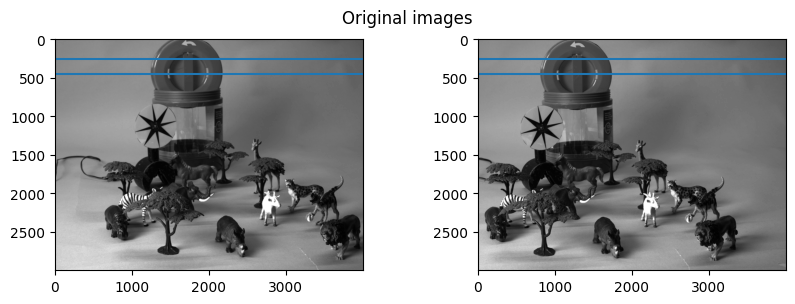

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].imshow(imgLeft, cmap="gray")
axes[1].imshow(imgRight, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Original images")
plt.savefig("original_images.png")
plt.show()

### Detect Keypoints and their Descriptors

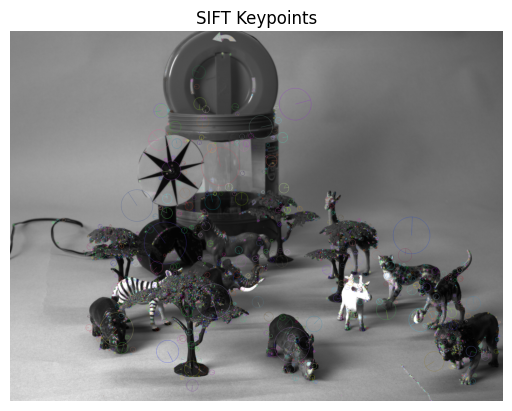

True

In [ ]:
# Detect keypoints and their descriptors
SIFT = cv.SIFT_create()
kp1, des1 = SIFT.detectAndCompute(imgLeft, None)
kp2, des2 = SIFT.detectAndCompute(imgRight, None)

# Visualize keypoints
imgSIFT = cv.drawKeypoints(imgLeft, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(cv.cvtColor(imgSIFT, cv.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()

cv.imwrite("SIFT_Keypoints.png", imgSIFT)

### Match Keypoints

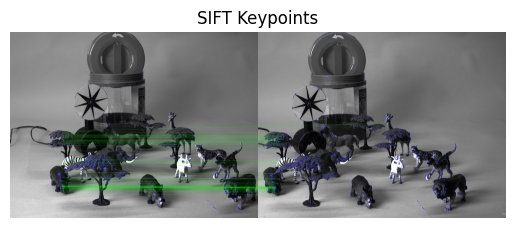

True

In [ ]:
# Match keypoints
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

# Draw keypoint matches
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), matchesMask=matchesMask[300:500], flags=cv.DrawMatchesFlags_DEFAULT)
keypoint_matches = cv.drawMatchesKnn(imgLeft, kp1, imgRight, kp2, matches[300:500], None, **draw_params)

plt.figure()
plt.imshow(cv.cvtColor(keypoint_matches, cv.COLOR_BGR2RGB))
plt.title('SIFT Keypoints')
plt.axis('off')
plt.show()

cv.imwrite("keypoint_matches.png", keypoint_matches)

### Epilines

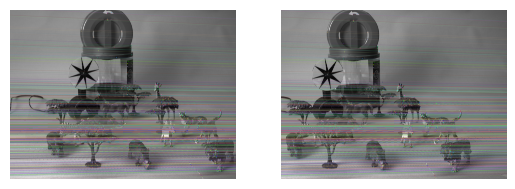

In [ ]:
# Calculate fundamental matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Select inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

# Visualize epilines
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(imgLeft, imgRight, lines1, pts1, pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(imgRight, imgLeft, lines2, pts2, pts1)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
axs[0].axis('off')

axs[1].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
axs[1].axis('off')
plt.show()

### Stereo Rectification

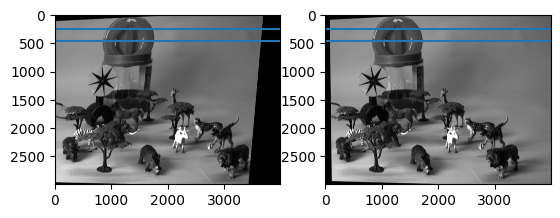

In [ ]:
# Stereo rectification
h1, w1 = imgLeft.shape
h2, w2 = imgRight.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1))

# Rectify images
imgLeft_rectified = cv.warpPerspective(imgLeft, H1, (w1, h1))
imgRight_rectified = cv.warpPerspective(imgRight, H2, (w2, h2))
cv.imwrite("rectified_1.png", imgLeft_rectified)
cv.imwrite("rectified_2.png", imgRight_rectified)

# Draw rectified images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(imgLeft_rectified, cmap="gray")
axes[1].imshow(imgRight_rectified, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.show()

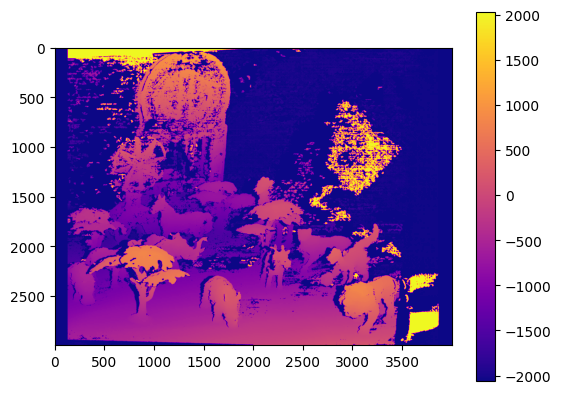

Disparity map successfully saved at ../../02_Utils/Images/04_Bilder_fuer_Doku\Bild03\disparity.jpg
Left image successfully saved at ../../02_Utils/Images/04_Bilder_fuer_Doku\Bild03\left.jpg
Right image successfully saved at ../../02_Utils/Images/04_Bilder_fuer_Doku\Bild03\right.jpg


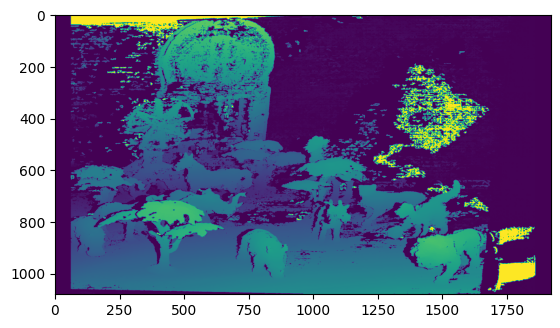

In [ ]:
# Calculate disparity map
block_size = 11
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=5,
    speckleWindowSize=200,
    speckleRange=2,
    disp12MaxDiff=0,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(imgLeft_rectified, imgRight_rectified)

plt.imshow(disparity_SGBM, cmap='plasma')
plt.colorbar()
plt.show()

disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)
disparity_SGBM = resize_to_full_hd(disparity_SGBM)
plt.imshow(disparity_SGBM)

save_path = f'../../02_Utils/Images/04_Bilder_fuer_Doku'
ordner = "Bild04"

new_folder_path = os.path.join(save_path, ordner)

os.makedirs(new_folder_path, exist_ok=True)

disparity_save_path = os.path.join(new_folder_path, 'disparity.jpg')
save_disparity_map(disparity_SGBM, disparity_save_path)

imgLeft_save_path = os.path.join(new_folder_path, 'left.jpg')
imgRight_save_path = os.path.join(new_folder_path, 'right.jpg')

success_left = cv.imwrite(imgLeft_save_path, imgLeft)
if success_left:
    print(f"Left image successfully saved at {imgLeft_save_path}")
else:
    print(f"Failed to save the left image at {imgLeft_save_path}")

success_right = cv.imwrite(imgRight_save_path, imgRight)
if success_right:
    print(f"Right image successfully saved at {imgRight_save_path}")
else:
    print(f"Failed to save the right image at {imgRight_save_path}")